# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import logging
import scipy
import sys
import sklearn.preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise import NormalPredictor
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity
from catboost import CatBoostClassifier, Pool
from dotenv import load_dotenv
import os
import boto3

/home/mle-user/sprint_4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
load_dotenv(".env")

In [ ]:
session = boto3.session.Session()

ENDPOINT = os.getenv("S3_ENDPOINT_URL")

session = boto3.Session(
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    region_name="ru-central1",
)

s3 = session.client(
    "s3", endpoint_url=ENDPOINT)

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [17]:
# Чтение данных о треках
tracks = pd.read_parquet('tracks.parquet')
# Чтение данных о названиях
catalog_names = pd.read_parquet('catalog_names.parquet')
# Чтение данных о взаимодействиях пользователей
interactions = pd.read_parquet('interactions.parquet')

In [18]:
print(tracks[["track_id", "albums", "artists", "genres"]].sample(5, random_state=52).sort_values("track_id").set_index("track_id").to_string())

                          albums           artists        genres
track_id                                                        
88957     [8201, 88361, 6045574]            [3543]  [11, 44, 75]
46257838               [6233977]         [4383623]       [3, 75]
48263278      [6575614, 7058305]  [678505, 611169]          [68]
61200248               [9527234]          [915312]          [11]
97110155              [19968185]         [4172355]     [14, 102]


In [19]:
print(catalog_names[["id", "type", "name"]].sample(5, random_state=52).sort_values("id").set_index("id").to_string())

           type                      name
id                                       
87080     album                  El Cielo
4989459   album             Edm Club Hits
9088932   track  Let´s Make A Night Of It
37540174  track                Чертополох
69405644  track             A Lucid Dream


In [20]:
print(interactions[["user_id", "track_id", "track_seq", "started_at"]].sample(5, random_state=52).sort_values("user_id").set_index(["user_id", "track_id"]).to_string())

                  track_seq started_at
user_id track_id                      
46179   29544272         37 2022-11-23
70117   28213677       1055 2022-09-18
72819   85090862        270 2022-08-08
471152  55682            18 2022-09-10
688081  220497          211 2022-02-22


# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [21]:
# Создание словарей для быстрого доступа к именам
artist_names = dict(catalog_names[catalog_names['type'] == 'artist'][['id', 'name']].values)
album_names = dict(catalog_names[catalog_names['type'] == 'album'][['id', 'name']].values)
genre_names = dict(catalog_names[catalog_names['type'] == 'genre'][['id', 'name']].values)

In [22]:
# Функция для замены идентификаторов именами
def replace_ids_with_names(ids, names_dict):
    return [names_dict.get(id, 'Unknown') for id in ids]

In [23]:
# Применение функции к столбцам
tracks['artists'] = tracks['artists'].apply(lambda ids: replace_ids_with_names(ids, artist_names))
tracks['albums'] = tracks['albums'].apply(lambda ids: replace_ids_with_names(ids, album_names))
tracks['genres'] = tracks['genres'].apply(lambda ids: replace_ids_with_names(ids, genre_names))

In [24]:
# Переименование столбцов для ясности
tracks.rename(columns={
    'albums': 'album_names',
    'artists': 'artist_names',
    'genres': 'genre_names'
}, inplace=True)

In [25]:
tracks.head(10)

,track_id,album_names,artist_names,genre_names
0,26,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]"
1,38,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]"
2,135,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop]
3,136,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop]
4,138,"[Wild Young Hearts, Wild Young Hearts, Don't U...",[Noisettes],[pop]
5,139,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop]
6,140,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop]
7,141,"[Wild Young Hearts, Wild Young Hearts, I Am Wo...",[Noisettes],[pop]
8,143,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop]
9,144,"[Lonesome Crow, Lonesome Crow]",[Scorpions],"[hardrock, allrock]"


In [26]:
tracks=tracks.explode("album_names")

In [27]:
tracks=tracks.explode("artist_names")

In [28]:
tracks=tracks.explode("genre_names")

In [29]:
tracks.head(10)

,track_id,album_names,artist_names,genre_names
0,26,Taller Children,Elizabeth & the Catapult,pop
0,26,Taller Children,Elizabeth & the Catapult,folk
0,26,Taller Children,Elizabeth & the Catapult,pop
0,26,Taller Children,Elizabeth & the Catapult,folk
1,38,Taller Children,Elizabeth & the Catapult,pop
1,38,Taller Children,Elizabeth & the Catapult,folk
1,38,Taller Children,Elizabeth & the Catapult,pop
1,38,Taller Children,Elizabeth & the Catapult,folk
2,135,Wild Young Hearts,Noisettes,pop
2,135,Wild Young Hearts,Noisettes,pop


In [33]:
tracks = tracks.drop_duplicates()

In [34]:
events = interactions.copy()
items = tracks.copy()

In [35]:
del tracks
del catalog_names
del interactions

In [36]:
# Проверка на пропущенные значения
print("Пропущенные значения в items:\n", items.isnull().sum())
print("Пропущенные значения в events:\n", events.isnull().sum())

# Проверка типов данных
print("\nТипы данных в items:\n", items.dtypes)
print("\nТипы данных в events:\n", events.dtypes)

Пропущенные значения в items:
 track_id            0
album_names        18
artist_names    41787
genre_names     33947
dtype: int64
Пропущенные значения в events:
 user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64

Типы данных в items:
 track_id         int64
album_names     object
artist_names    object
genre_names     object
dtype: object

Типы данных в events:
 user_id                int32
track_id               int32
track_seq              int16
started_at    datetime64[ns]
dtype: object


In [37]:
# Проверка на уникальность track_id в items
if items['track_id'].duplicated().any():
    print("В items есть дублирующиеся track_id")
else:
    print("В items все track_id уникальны")

В items есть дублирующиеся track_id


In [38]:
items['track_id'] = items['track_id'].astype('int32')

In [40]:
# Найдем треки с отсутствующими исполнителями
#tracks_without_artists = items[items['artist_names'].apply(lambda x: len(x) == 0)]
tracks_without_artists = items[items['artist_names'].apply(lambda x: len(x) == 0 if isinstance(x, list) else pd.isna(x))]
print("\nТреки без исполнителей:\n")
tracks_without_artists.head(10)


Треки без исполнителей:



,track_id,album_names,artist_names,genre_names
146031,3599314,In Search of Sunrise 1,NaN,electronics
146031,3599314,In Search of Sunrise 1,NaN,trance
146163,3599591,Tales from the Albums Magik: the Remix Edition,NaN,electronics
146163,3599591,Tales from the Albums Magik: the Remix Edition,NaN,trance
177544,4790215,A State of Trance 2012,NaN,electronics
177544,4790215,A State of Trance 2012,NaN,trance
218922,10063296,Тёплое Солнце,NaN,pop
218922,10063296,Тёплое Солнце,NaN,ruspop
231455,12122918,Kompakt: Total 1,NaN,electronics
266746,16610995,Space Odyssey: Mars,NaN,electronics


In [41]:
# Найдем треки с отсутствующими альбомами
#tracks_without_albums = items[items['album_names'].apply(lambda x: len(x) == 0)]
tracks_without_albums = items[items['album_names'].apply(lambda x: len(x) == 0 if isinstance(x, list) else pd.isna(x))]
print("\nТреки без альбомов:\n")
tracks_without_albums.head(10)


Треки без альбомов:



,track_id,album_names,artist_names,genre_names
310821,20200372,NaN,NaN,NaN
310826,20200380,NaN,NaN,NaN
312469,20305116,NaN,NaN,NaN
312474,20305121,NaN,NaN,NaN
320353,20756854,NaN,NaN,NaN
326588,21196099,NaN,NaN,NaN
326592,21196103,NaN,NaN,NaN
326594,21196105,NaN,NaN,NaN
326596,21196107,NaN,NaN,NaN
326598,21196109,NaN,NaN,NaN


In [42]:
# Найдем треки с отсутствующими жанрами
#tracks_without_genres = items[items['genre_names'].apply(lambda x: len(x) == 0)]
tracks_without_genres = items[items['genre_names'].apply(lambda x: len(x) == 0 if isinstance(x, list) else pd.isna(x))]
print("\nТреки без жанров:\n")
tracks_without_genres.head(10)


Треки без жанров:



,track_id,album_names,artist_names,genre_names
490,2520,Best Of / 20th Century - Christmas,98º,NaN
490,2520,Ultimate Christmas Collection,98º,NaN
490,2520,I Am Christmas,98º,NaN
490,2520,100 Christmas,98º,NaN
490,2520,This Christmas,98º,NaN
490,2520,Festive Christmas,98º,NaN
490,2520,Christmas From Your Childhood,98º,NaN
490,2520,Christmas Love Songs,98º,NaN
3069,16776,Christmas Pre-Cleared Compilation,Marvin Gaye,NaN
3069,16776,SPP Lamictal Christmas Soul,Marvin Gaye,NaN


In [44]:
# Заполнение пропущенных значений в items
items['album_names'] = items['album_names'].apply(lambda x: len(x) == 0 if isinstance(x, list) else ['Unknown Album'])
items['artist_names'] = items['artist_names'].apply(lambda x: len(x) == 0 if isinstance(x, list) else ['Unknown Artist'])
items['genre_names'] = items['genre_names'].apply(lambda x: len(x) == 0 if isinstance(x, list) else ['Unknown Genre'])

In [45]:
items.query("track_id == 20200372")

,track_id,album_names,artist_names,genre_names
310821,20200372,[Unknown Album],[Unknown Artist],[Unknown Genre]


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

<div class="alert alert-success">
<h2> Комментарий студента</h2>

1) Выводы:
 - Данные разрознены по типам в events
 - Есть пустые значения в items

2) Действия:
 - Привел все идентификаторы в events к типу int64.
 - добавление данных в items [Unknown Album] [Unknown Artist] [Unknown Genre]

</div>

# === ЭТАП 2 ===

# EDA

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd

/home/mle-user/sprint_4/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


Распределение количества прослушанных треков.

In [52]:
# Группировка по user_id и подсчет количества уникальных track_id
user_track_count = events.groupby('user_id')['track_id'].nunique().reset_index()
user_track_count.columns = ['user_id', 'track_count']

In [56]:
user_track_count_1 = user_track_count[user_track_count['track_count'].apply(lambda x: not np.isinf(x))]

In [54]:
user_track_count.isnull().sum()

user_id        0
track_count    0
dtype: int64

In [ ]:
len()

1373221

/home/mle-user/sprint_4/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mle-user/sprint_4/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


OptionError: No such keys(s): 'mode.use_inf_as_null'

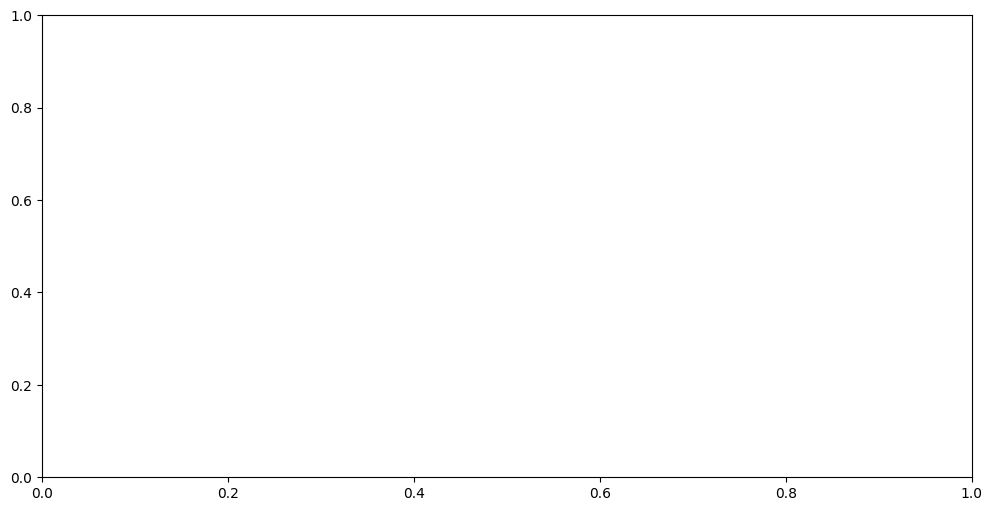

In [ ]:
# Очистка данных от NaN и Inf перед визуализацией
#user_track_count = user_track_count.dropna(subset=['track_count'])
#user_track_count = user_track_count[user_track_count['track_count'].apply(lambda x: not np.isinf(x))]
# Замена Inf на NaN
user_track_count['track_count'] = user_track_count['track_count'].replace([np.inf, -np.inf], np.nan)
# Очистка данных от NaN
user_track_count = user_track_count.dropna(subset=['track_count'])
# Визуализация распределения количества прослушанных треков
plt.figure(figsize=(12, 6))
sns.lineplot(user_track_count['track_count'])
plt.title('Распределение количества прослушанных треков пользователем')
plt.xlabel('Количество уникальных треков')
plt.ylabel('Количество пользователей')
plt.show()

Наиболее популярные треки

/home/mle-user/sprint_4/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mle-user/sprint_4/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mle-user/sprint_4/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


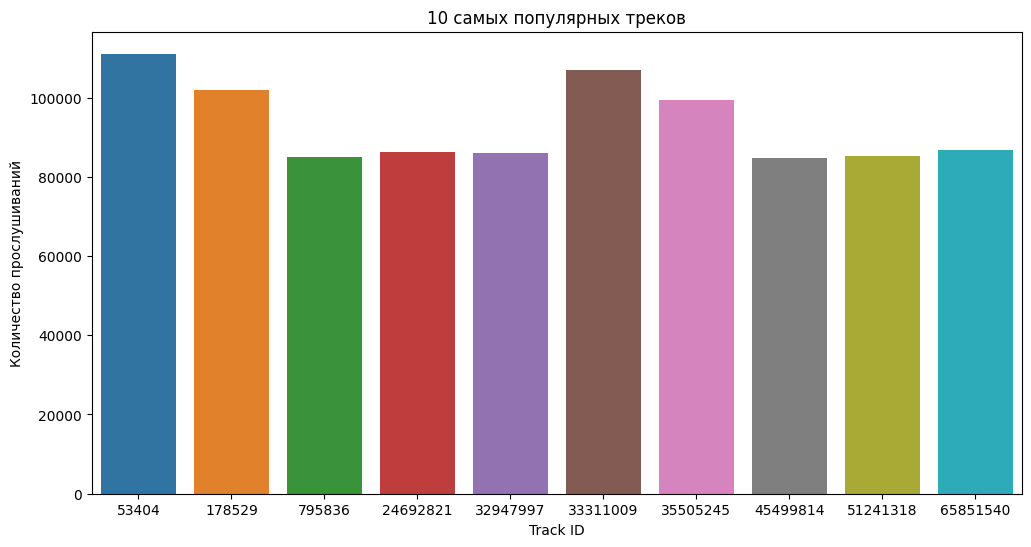

In [48]:
# Группировка по track_id и подсчет количества прослушиваний
track_popularity = events['track_id'].value_counts().reset_index()
track_popularity.columns = ['track_id', 'play_count']

# Визуализация 10 самых популярных треков
plt.figure(figsize=(12, 6))
sns.barplot(x='track_id', y='play_count', data=track_popularity.head(10))
plt.title('10 самых популярных треков')
plt.xlabel('Track ID')
plt.ylabel('Количество прослушиваний')
plt.show()

Наиболее популярные жанры

In [ ]:
# Соединение таблиц
merged_df = dd.merge(events, items, on='track_id', how='left')

# Развернем списки жанров в отдельные строки для правильной группировки
merged_exploded = merged_df.explode('genre_names')

# Очистка данных от NaN перед группировкой
merged_exploded = merged_exploded.dropna(subset=['genre_names'])

# Группировка по genre_names и подсчет количества прослушиваний
genre_popularity = merged_exploded['genre_names'].value_counts().reset_index()
genre_popularity.columns = ['genre', 'play_count']

# Визуализация 10 самых популярных жанров
plt.figure(figsize=(12, 6))
sns.barplot(x='genre', y='play_count', data=genre_popularity.head(10))
plt.title('10 самых популярных жанров')
plt.xlabel('Жанр')
plt.ylabel('Количество прослушиваний')
plt.xticks(rotation=45)
plt.show()

Треки, которые никто не прослушал

In [ ]:
# Найти track_id, которые есть в items, но нет в events
unlistened_tracks = items[~items['track_id'].isin(events['track_id'])]

# Вывод первых 10 треков, которые никто не прослушивал
print("Первые 10 треков, которые никто не прослушал:")
print(unlistened_tracks.head(10))

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

# Топ популярных

Рассчитаем рекомендации как топ популярных.

# Персональные

Рассчитаем персональные рекомендации.

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.